In [1]:
import numpy as np
import cv2
import mnist
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

import os
plt.figure(figsize=(20,10))
plt.style.use('fivethirtyeight')
tf.config.run_functions_eagerly(True)

<Figure size 1440x720 with 0 Axes>

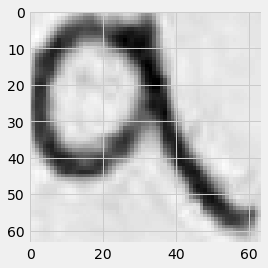

In [2]:
image = cv2.imread("Training/a/12.jpg", 0) # read in grayscale
image.shape
plt.imshow(image, cmap="gray")

In [3]:
alphabets = "abcdefghijklmnopqrstuvwxyz"
labels = []
training_images = []
for char in alphabets:
    for image in os.listdir(f"Training/{char}"):
        labels.append(char)
        training_images.append(cv2.imread(f"Training/{char}/{image}", 0))
training_images = np.array(training_images)  # make it a numpy array

    

In [4]:
# convert labels to numbers. a->0, b->1... etc
print(f"Before: {labels[100]}, {labels[100]}")
for i in range(len(labels)):
    labels[i] = alphabets.index(labels[i])
print(f"after: {labels[100]}, {labels[100]}")



Before: d, d
after: 3, 3


In [5]:
training_images.shape

(832, 64, 64)

In [6]:
training_images = (training_images/255) - 0.5  # make tha range between -0.5 to + 0.5
training_images = training_images.reshape((-1, 4096))

In [7]:
training_images.shape

(832, 4096)

In [8]:
training_images[0]

array([-0.01764706, -0.02156863, -0.00980392, ..., -0.0372549 ,
       -0.04117647, -0.01764706])

In [10]:
64*64

4096

In [9]:
detected_alphabets = []  # stores grayscale 64x64 sub-array of the main image array containing detected alphabets
positions = []    # stores positions of the detected alphabets

def getContours(img, output, img_to_slice):
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    print(len(contours))
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 29:
            # cv2.drawContours(output, cnt, -1, (0, 0, 255), 2)
            peri = cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
            x_, y_, w_, h_ = cv2.boundingRect(approx)
            positions.append((x_, y_, w_, h_))
            cv2.rectangle(output, (x_, y_), (x_ + w_, y_ + h_), (0, 0, 255), 2)
         
            letter = img_to_slice[y_:y_+h_, x_:x_+w_]
            resized_letter = cv2.resize(letter, (64,64))
            
            detected_alphabets.append(resized_letter)
            # cv2.putText(output, str(count), (x_,y_), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0,255,0,255), 1)

  

534


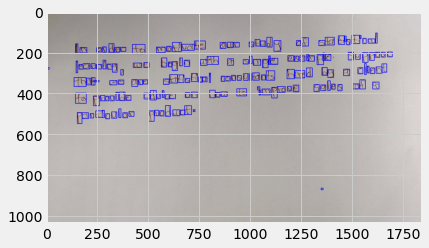

In [10]:
img_test = cv2.imread("sample2.jpg")
gray = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 8)
imgCanny = cv2.Canny(thresh, threshold1=234, threshold2=137)
kernel = np.ones((2, 2))
imDil = cv2.dilate(imgCanny, kernel, iterations=1)
imCopy = img_test.copy()


getContours(imDil, imCopy, thresh)
plt.imshow(imCopy)

In [11]:
detected_alphabets = np.array(detected_alphabets)
print(f"Shape before: {detected_alphabets.shape}")      # each index contains a 2D array containing pixels. Dimentions correspond to the X and Y axes
detected_alphabets = (detected_alphabets / 255) - 0.5
detected_alphabets = detected_alphabets.reshape((-1, 4096))   # Each index contains a 1-D array containing the pixels of an aplhabet
print(f"Shape after: {detected_alphabets.shape}") 

Shape before: (168, 64, 64)
Shape after: (168, 4096)


In [12]:
detected_alphabets.shape

(168, 4096)

In [13]:
model = Sequential()
model.add(Dense(64, activation="relu", input_dim=4096))
model.add(Dense(64, activation="relu"))
model.add(Dense(26, activation="softmax"))
# a model with 3 layers, first 2 have 64 neurons and relu activation. Last layer has 26 neurons (1 for each alphabet) and softmax activation function

In [14]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [15]:
# train the model
model.fit(
    training_images,
    to_categorical(labels),
    epochs=5,
    batch_size=32
)

Epoch 1/5
26/26 [==============================] - 0s 13ms/step - loss: 2.5644 - accuracy: 0.3149
Epoch 2/5
26/26 [==============================] - 0s 13ms/step - loss: 1.2470 - accuracy: 0.7188
Epoch 3/5
26/26 [==============================] - 0s 13ms/step - loss: 0.6001 - accuracy: 0.8786
Epoch 4/5
26/26 [==============================] - 0s 13ms/step - loss: 0.3423 - accuracy: 0.9267
Epoch 5/5
26/26 [==============================] - 0s 13ms/step - loss: 0.2192 - accuracy: 0.9567


In [16]:
model.evaluate(
    training_images,
    to_categorical(labels)    
)

26/26 [==============================] - 0s 6ms/step - loss: 0.1534 - accuracy: 0.9844


[0.15344642102718353, 0.984375]

In [17]:
predictions = model.predict(detected_alphabets[:5])
predictions = np.argmax(predictions, axis=1)


In [18]:
print(predictions)
for prediction in predictions:
    print(alphabets[prediction])


[ 8 17 17 17  8]
i
r
r
r
i


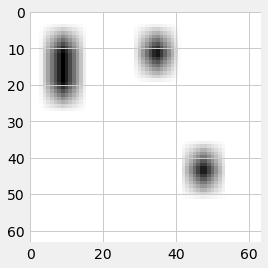

In [19]:
results = detected_alphabets.reshape(-1,64,64)
plt.imshow(results[0], cmap="gray")


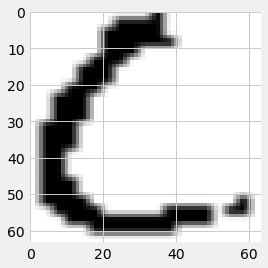

In [20]:
plt.imshow(results[1], cmap="gray")

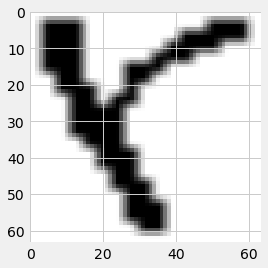

In [21]:
plt.imshow(results[2], cmap="gray")

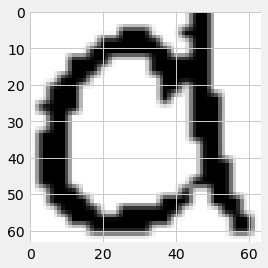

In [22]:
plt.imshow(results[3], cmap="gray")

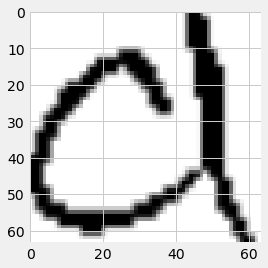

In [23]:
plt.imshow(results[4], cmap="gray")